# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
from comet_ml import Experiment

#@title CometML set up
project_name = 'project Classification'
workspace = ''
api_key = ''

In [3]:
# запуск эксперимента

experiment = Experiment(project_name=project_name, workspace=workspace, api_key = api_key, log_code=True)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/apiona13/project-classification/2a0dfdff10ab4d4e9a3c9a26bc70f65d



## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [4]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Добавим описание данных в датасете:

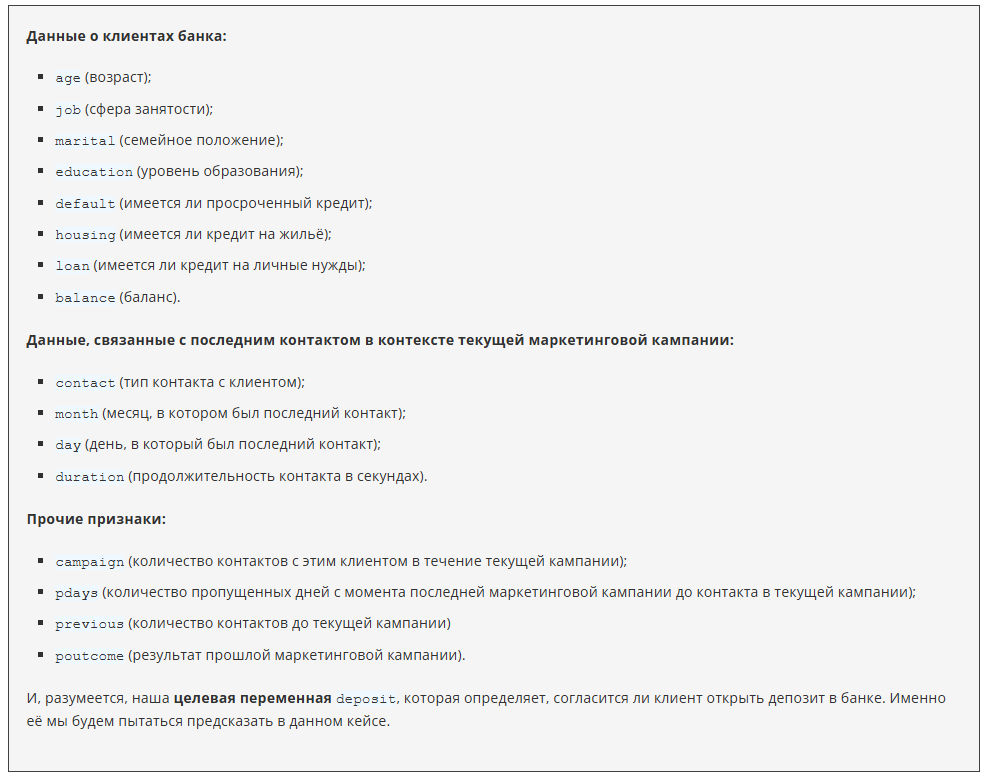

In [5]:
# исследуем данные на предмет пропусков 

df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [6]:
# Исследуем признаки на неявные пропуски
df['job'].value_counts()


job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [7]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].replace({r'\$': '', ',': '.', ' ':''}, regex=True).astype(float)
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [8]:
df['balance'].mean().round(3)

1529.129

In [9]:
# обработка пропусков в признаки balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [10]:
df['balance'].mean().round(3)

1526.936

In [11]:
# Исследуем признак education на неявные пропуски
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [12]:
# обработка пропусков в категориальных признаках: job и education, заменив их на модальные значения

df['job'] = df['job'].replace('unknown', df['job'].mode()[0], regex=True)
df['education'] = df['education'].replace('unknown', df['education'].mode()[0], regex=True)

In [13]:
most_freq_job = df['job'].mode()[0]
most_freq_edu = df['education'].mode()[0]

df_copy = df[(df['job'] == most_freq_job) & (df['education'] == most_freq_edu)]
df_copy['balance'].mean().round(3)

1598.883

In [14]:
# вводим функцию для нахождения выбросов для признака balance по методу Тьюки

def outliers_iqr(data, feature):
    """ Фнукция для нахождения выбросов

    Args:
        data (DataFrame): Передаем датафрейм
        feature (DataFrame[column]): Определяем столбец с признаком

    Returns:
        DataFrame: Возвращаем 2 датафрейма, 1 с очищенными данными, другой с выбросами
    """
    x = data[feature]
    quantile_1, quantile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quantile_3 - quantile_1
    lower_bound = quantile_1 - (1.5 * iqr)
    upper_bound = quantile_3 + (1.5 * iqr)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned   

# Применяем функцию для поиска выбросов для признака balance

outliers, cleaned_df = outliers_iqr(df, 'balance')

# выводим количество выбросов и очищенного датасета:

print(f"Количество выбросов, найденных с помощью метода Тьюки: {outliers.shape[0]}")
print(f'Размер очищенного датасета после удаления выбросов: {cleaned_df.shape[0]}')

Количество выбросов, найденных с помощью метода Тьюки: 1057
Размер очищенного датасета после удаления выбросов: 10105


In [15]:
# Проверим, какие границы были определены для определения выбросов

q3 = np.percentile(df['balance'], 75)
q1 = np.percentile(df['balance'], 25)
lower_bound = q1 - (1.5 * (q3 - q1))
upper_bound = q3 + (1.5 * (q3 - q1))

print('Нижнияя граница: ', lower_bound)
print('Верхняя граница: ', upper_bound)

Нижнияя граница:  -2241.0
Верхняя граница:  4063.0


## Часть 2:  Разведывательный анализ

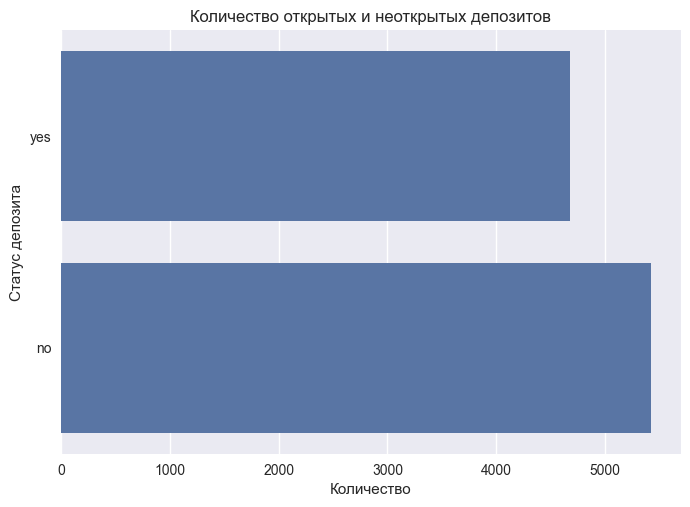

In [16]:
# изучение соотношений классов в наших данных на предмет несбалансированности, визуализация результата

sns.countplot(cleaned_df['deposit'])
plt.title("Количество открытых и неоткрытых депозитов")
plt.xlabel("Количество")
plt.ylabel("Статус депозита")

experiment.log_figure('target_feature_distribution', plt)
plt.show();


In [17]:
# соотношение классов данных на предмет несбалансированности

cleaned_df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

**Их графика и подсчета целевого признака видно, что данные сбалансированы**

In [18]:
# описательные статистики для количественных переменных

cleaned_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


Из описательных статистик видно, что:
* возраст клиентов составляет от 18 до 95 лет, нет несовершеннолетних
* Баланс есть как отрицательный, так и положительный
* Большой разброс длительности звонка, от 2 до почти 4000 секунд

In [19]:
# описательные статистики для категориальных переменных

cleaned_df.describe(include='object').T

,count,unique,top,freq
job,10105,11,management,2315
marital,10105,3,married,5715
education,10105,3,secondary,5517
default,10105,2,no,9939
housing,10105,2,no,5243
loan,10105,2,no,8712
contact,10105,3,cellular,7283
month,10105,12,may,2617
poutcome,10105,4,unknown,7570
deposit,10105,2,no,5424


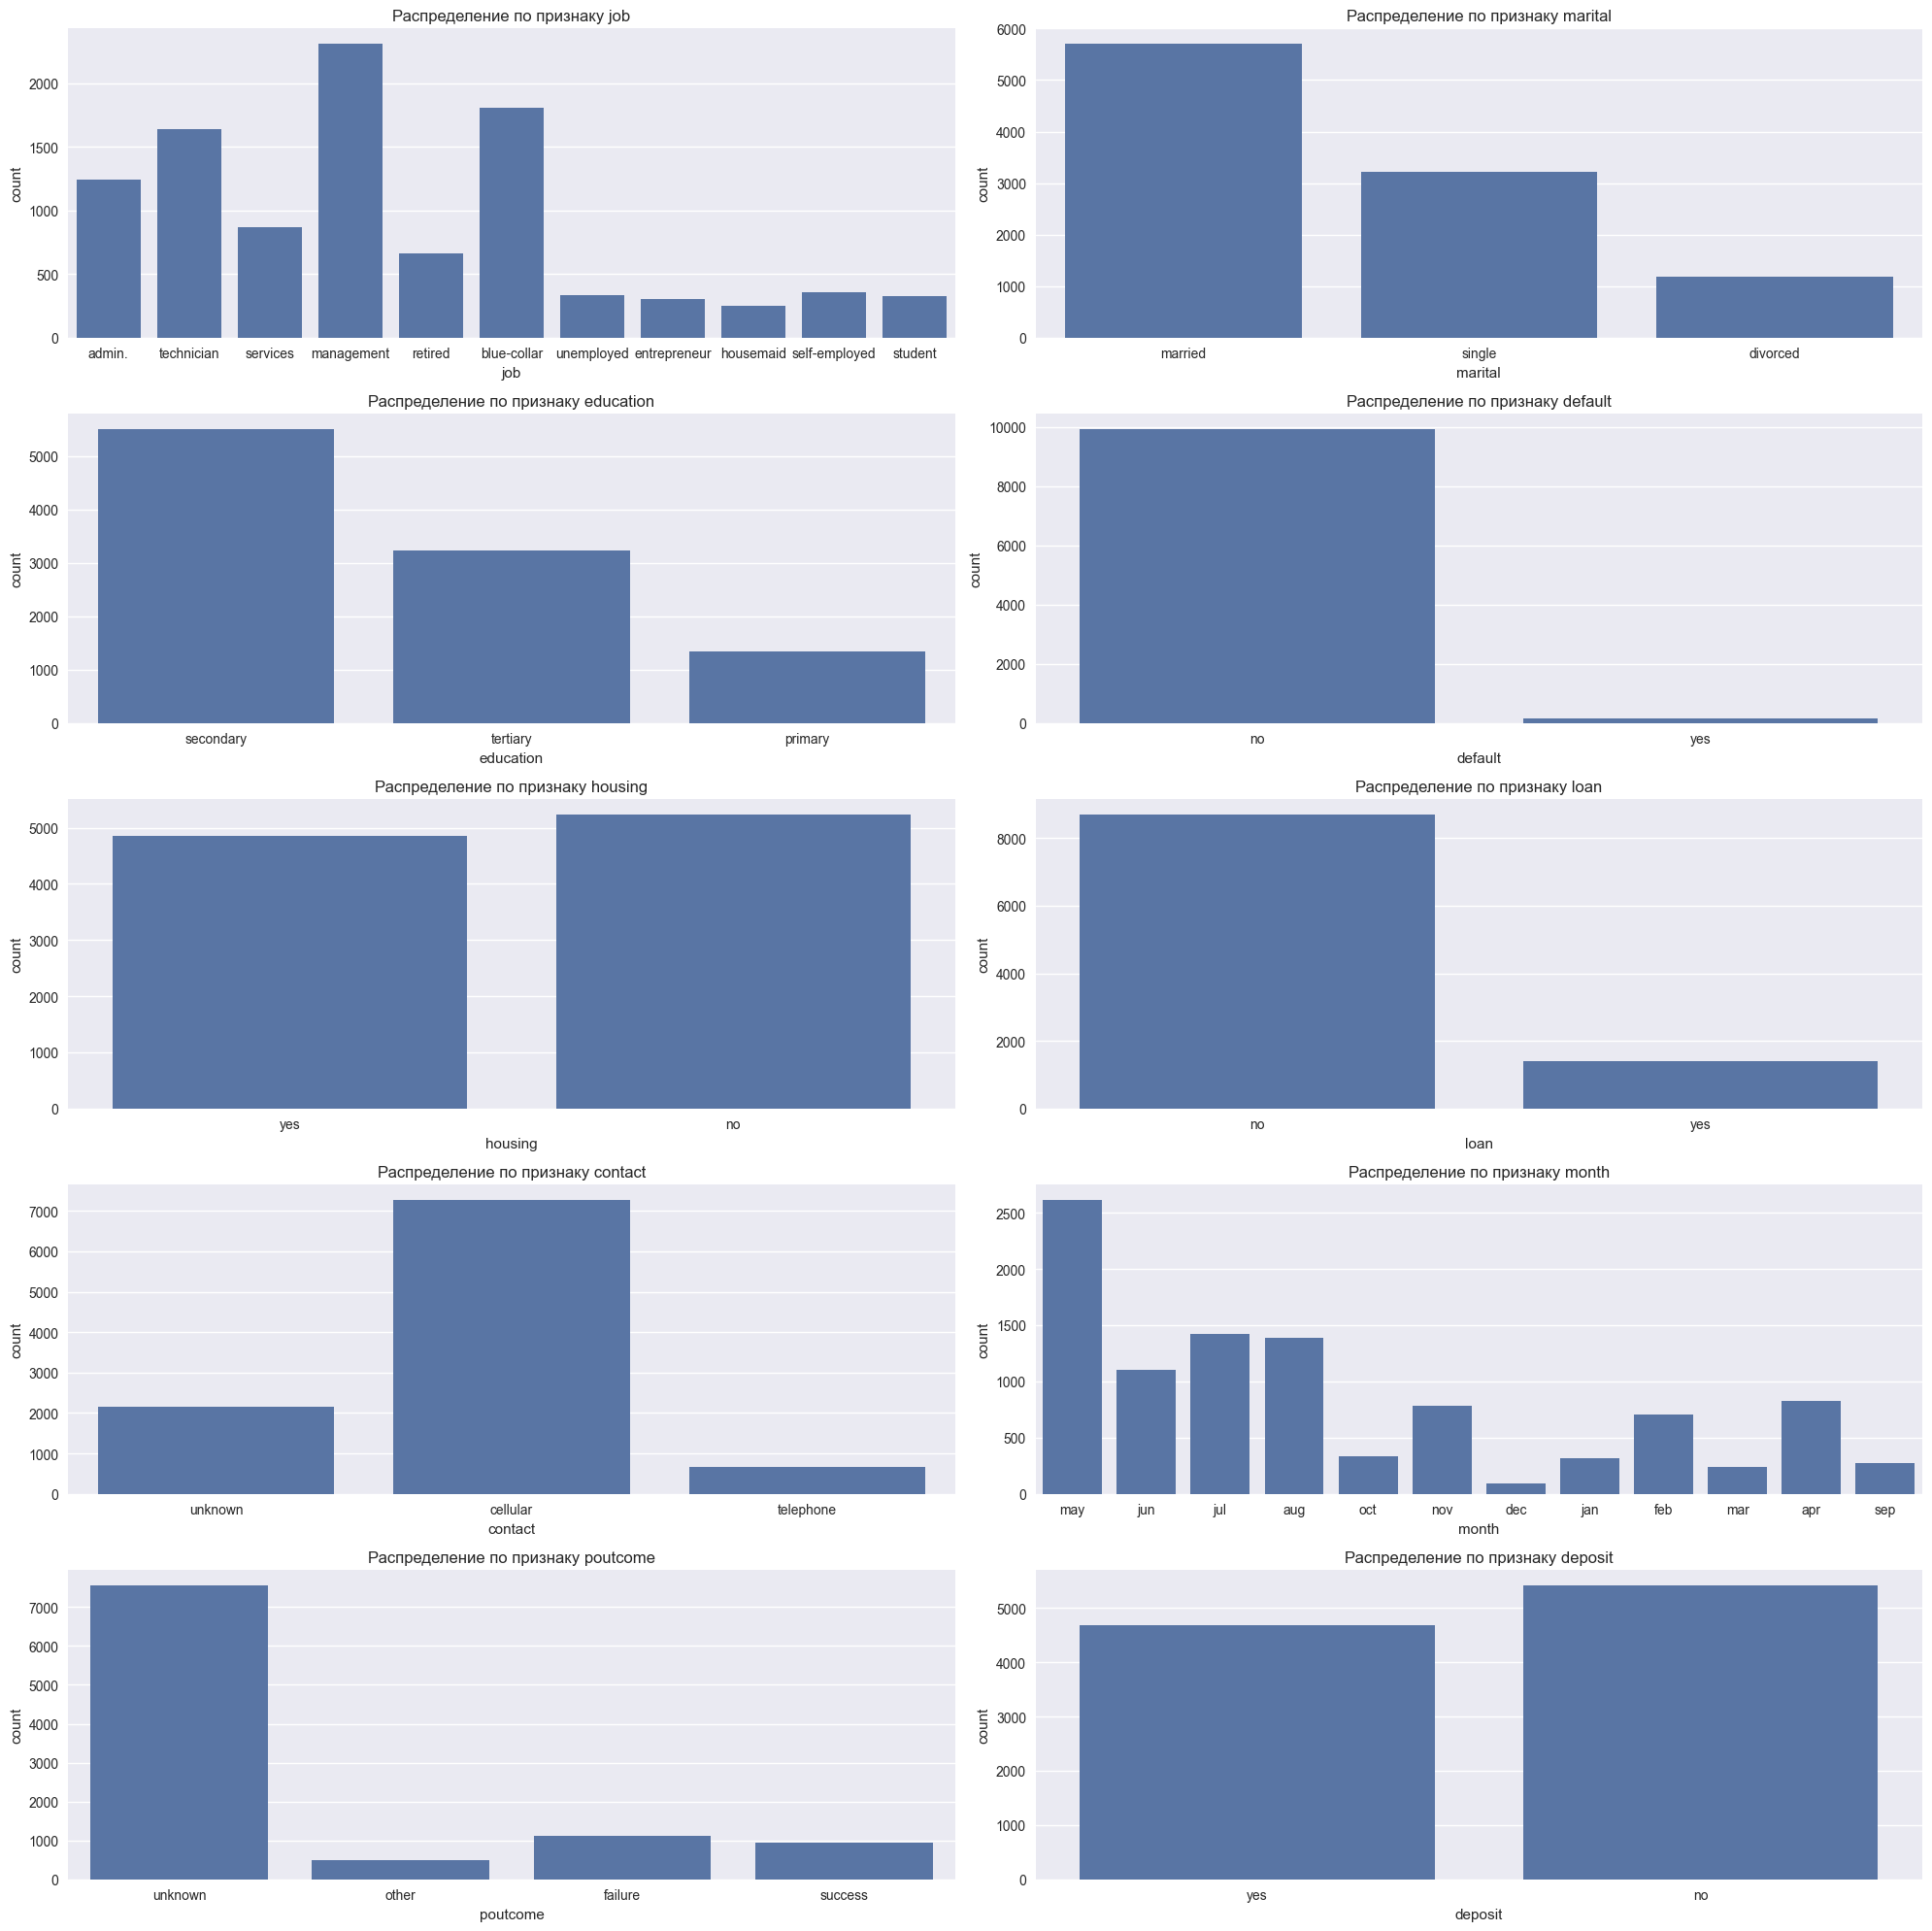

In [20]:
# построим визуализацию для категориальных признаков, иллюстрирующие результаты

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

# Перебираем все признаки и рисуем графики
for i, feature in enumerate(categorical_features):
    
    # Получаем координаты подграфика
    ax = axes[i // 2, i % 2]
    sns.countplot(data=cleaned_df, x=feature, ax=ax)
    ax.set_title(f"Распределение по признаку {feature}")  

# Настроим отступы и отображение
plt.tight_layout()

experiment.log_figure('Category_feature_distribution', plt)
plt.show();

Из описательных статистики и визуализации категориальных признаков, мы видим, что:

* Клиенты заняты в 11 сферах труда, чаще всего это сфера менеджмента; 
* у большей части клиентов, нет просроченного кредита;
* кампания проводилась в течение всех 12 месяцев;
* Чаще всего, контакт с клиентами был в маю, реже всего в декабре;
* ~50% клиентов, состоят в замужестве;
* по большой части клиентов нет данных о результатах за предыдущую кампанию;


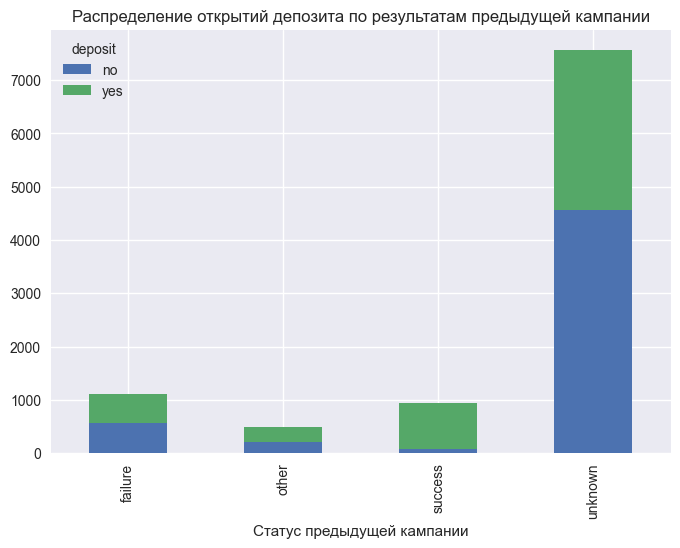

In [21]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач

types = cleaned_df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')
plt.xlabel('Статус предыдущей кампании')
plt.title('Распределение открытий депозита по результатам предыдущей кампании')
plt.show();

**Видим, что клиенты, откывшие депозит в рамках прошлой кампаний, открыли депозит повторно**

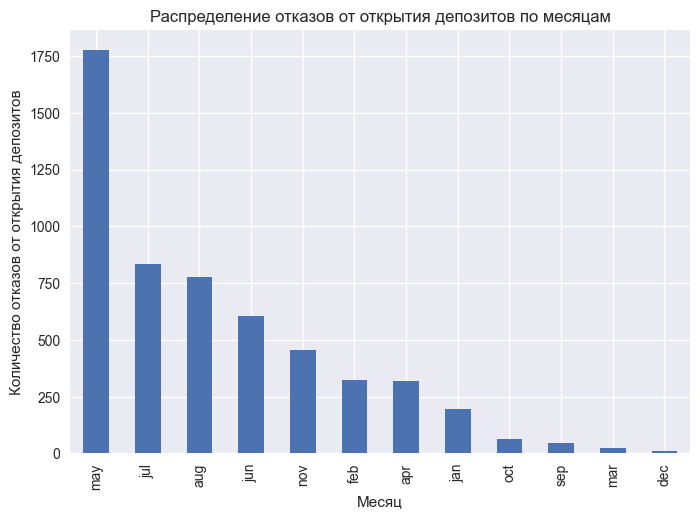

In [22]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит

monthes = cleaned_df[cleaned_df['deposit'] == 'no'].groupby('month', as_index=False)['deposit'].size().sort_values(by='size', ascending=False)
monthes.plot(kind='bar', x='month', y='size', legend=False)
plt.xlabel('Месяц')
plt.ylabel('Количество отказов от открытия депозитов')
plt.title('Распределение отказов от открытия депозитов по месяцам')
plt.show();

**Наибольшое количество отказов было в мае, а наименьшее в декабре, что коррелируется с общим количеством контактов в рамках кампании**

In [23]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_range(x):
    """ Функция для определения возрастных категорий

    Args:
        x (int): значение возраста в датафрейме

    Returns:
        object: Категория возраста
    """
    if x < 30:
        x = 'young'
    elif 30 <= x < 40:
        x = 'low mid age'
    elif 40 <= x < 50:
        x = 'mid age'
    elif 50 <= x < 60:
        x = 'high mid age'  
    elif 60 <= x:
        x = 'senior'
    return x

# Применяем функцию к очищенному датафрейму

cleaned_df['age_category'] = cleaned_df['age'].apply(age_range)

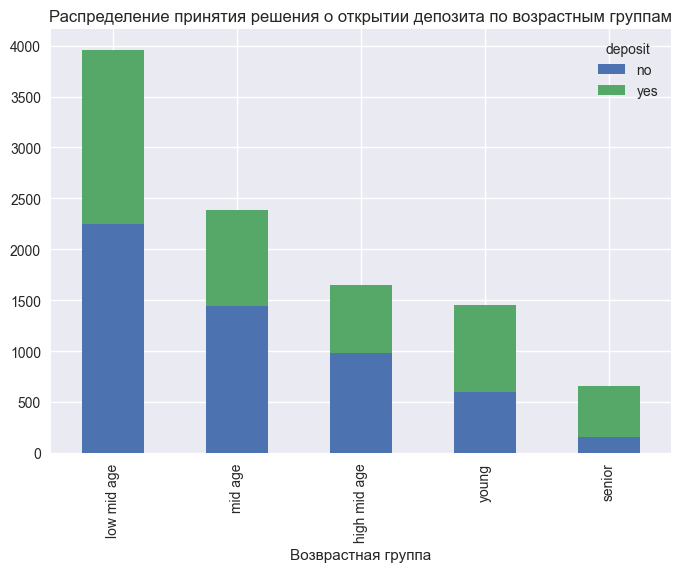

In [24]:
# Визуализируем в каких группах более склонны открывать депозит, чем отказываться от предложения

age_data = cleaned_df.groupby('age_category')['deposit'].value_counts(normalize=False).unstack()
age_data = age_data.loc[age_data.sum(axis=1).sort_values(ascending=False).index]
age_data.plot(kind='bar', stacked='True');

plt.xlabel('Возврастная группа')
plt.title('Распределение принятия решения о открытии депозита по возрастным группам')
plt.show();


**Как видно, наиболее склонными к отрытию депозита являются молодые и пожилые люди, однако в количественном значении эти группы уступают среднему возврасту**

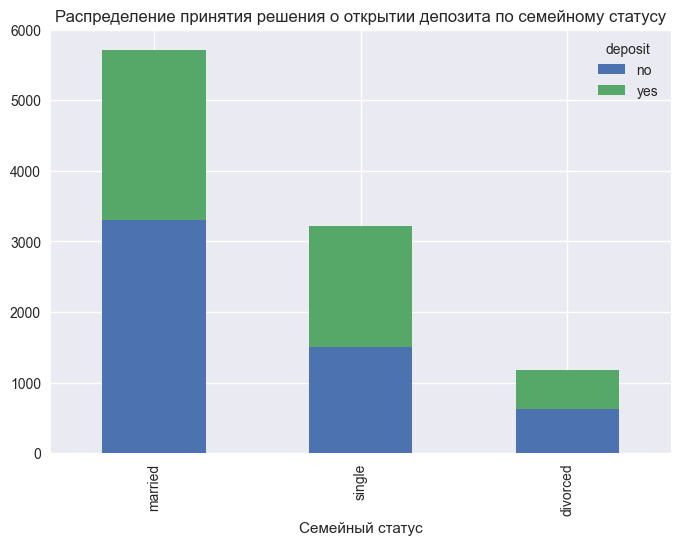

In [25]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса

marital_data = cleaned_df.groupby('marital')['deposit'].value_counts(normalize=False).unstack()
marital_data = marital_data.loc[marital_data.sum(axis=1).sort_values(ascending=False).index]
marital_data.plot(kind='bar', stacked='True')

plt.xlabel('Семейный статус')
plt.title('Распределение принятия решения о открытии депозита по семейному статусу')
plt.show();


**Клиенты без семьи, чаще открывают депозит, чем клиенты состоящие в браке**

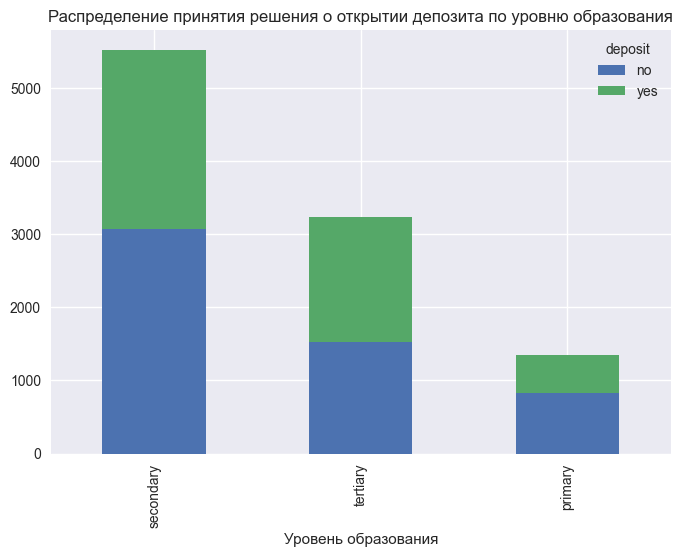

In [26]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от образования

edu_data = cleaned_df.groupby('education')['deposit'].value_counts(normalize=False).unstack()
edu_data = edu_data.loc[edu_data.sum(axis=1).sort_values(ascending=False).index]
edu_data.plot(kind='bar', stacked='True')

plt.xlabel('Уровень образования')
plt.title('Распределение принятия решения о открытии депозита по уровню образования')
plt.show();

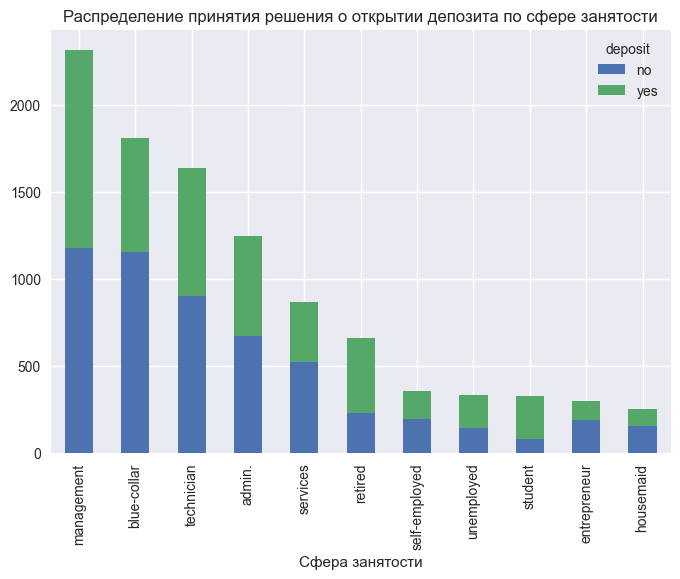

In [27]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

job_data = cleaned_df.groupby('job')['deposit'].value_counts(normalize=False).unstack()
job_data = job_data.loc[job_data.sum(axis=1).sort_values(ascending=False).index]
job_data.plot(kind='bar', stacked='True')

plt.xlabel('Сфера занятости')
plt.title('Распределение принятия решения о открытии депозита по сфере занятости')
plt.show();

**Как видим, в разделе профессиональной сферы занятости, пенсионеры и студенты, склонны к отрытию депозита, что также коррелируется с возрастными группами**

In [28]:
# построим сводную таблицу, чтобы определить, люди с каким образованием и семейным статусом наиболее склонны к отрытию либо неоткрытию депозита
# для начала отфильтруем датафреймы

no_data = cleaned_df[cleaned_df['deposit'] == 'no']
yes_data = cleaned_df[cleaned_df['deposit'] == 'yes']

In [29]:
# Сводная таблица для тех, кто открыл депозит
pivot_yes = yes_data.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

# Сводная таблица для тех, кто не открыл депозит
pivot_no = no_data.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

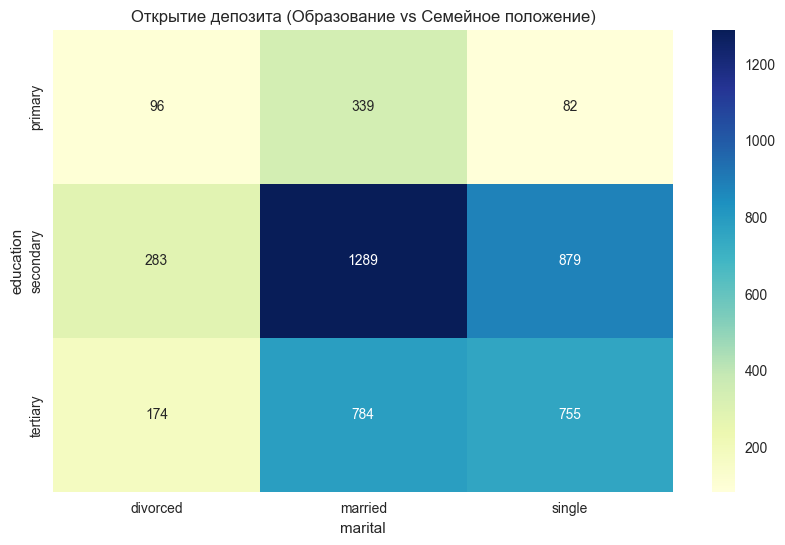

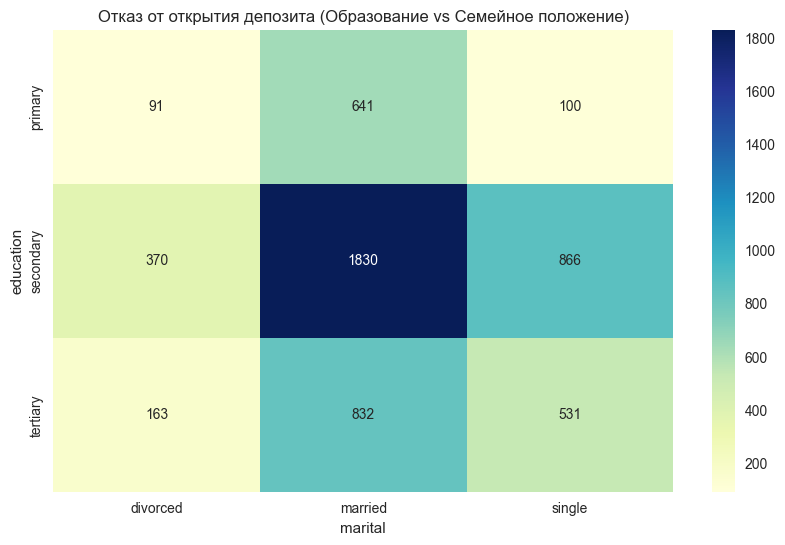

In [30]:
# Построение тепловой карты для тех, кто открыл депозит
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_yes, annot=True, cmap='YlGnBu', fmt='d', cbar=True)
plt.title('Открытие депозита (Образование vs Семейное положение)')
experiment.log_figure('open_deposit_by_marital_status_vs_education', plt)
plt.show();

# Построение тепловой карты для тех, кто не открыл депозит
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_no, annot=True, cmap='YlGnBu', fmt='d', cbar=True)
plt.title('Отказ от открытия депозита (Образование vs Семейное положение)')
experiment.log_figure('not_open_deposit_by_marital_status_vs_education', plt)
plt.show();

* В обоих случаях, видно, что наибольшая группа, это люди полным среднем образованием и состоящие в браке.
* Из тепловой карты, клиентов открывших депозит, видим, что клиенты вне брака и с высшим образьвание более склонны к отрытию, чем к не
* С другой стороны, клиенты в браке и с начальным образованием, более склонны к неотрытию депозита

## Часть 3: Преобразование данных

In [31]:
# преобразуем признаки education и age_category

LE = LabelEncoder()
 
cleaned_df['education'] = LE.fit_transform(cleaned_df['education'])
cleaned_df['age_category'] = LE.fit_transform(cleaned_df['age_category'])

In [32]:
cleaned_df['education'].sum()

11995

In [33]:
# преобразуем бинарные переменные в представление из нулей и единиц для признаков, в которые данные представленны в виде 'yes' и 'no'

cleaned_df['deposit'] = cleaned_df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
cleaned_df['default'] = cleaned_df['default'].apply(lambda x: 1 if x=='yes' else 0)
cleaned_df['housing'] = cleaned_df['housing'].apply(lambda x: 1 if x=='yes' else 0)
cleaned_df['loan'] = cleaned_df['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [34]:
cleaned_df['deposit'].std().round(3)

0.499

In [35]:
total_mean = cleaned_df['default'].mean() + cleaned_df['housing'].mean() + cleaned_df['loan'].mean()
print(round(total_mean,3))

0.635


In [36]:
# создадим дамми-переменные и соединим их с основным датафреймом

dummies_df = pd.get_dummies(cleaned_df[['job', 'marital', 'contact', 'month', 'poutcome']], dtype='int')
data = pd.concat([cleaned_df, dummies_df], axis=1)
data = data.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

In [37]:
data.shape

(10105, 46)

{'web': 'https://www.comet.com/api/image/download?imageId=ccfcbffa98d24189a5cd4885b8359747&experimentKey=2a0dfdff10ab4d4e9a3c9a26bc70f65d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ccfcbffa98d24189a5cd4885b8359747&experimentKey=2a0dfdff10ab4d4e9a3c9a26bc70f65d',
 'imageId': 'ccfcbffa98d24189a5cd4885b8359747'}

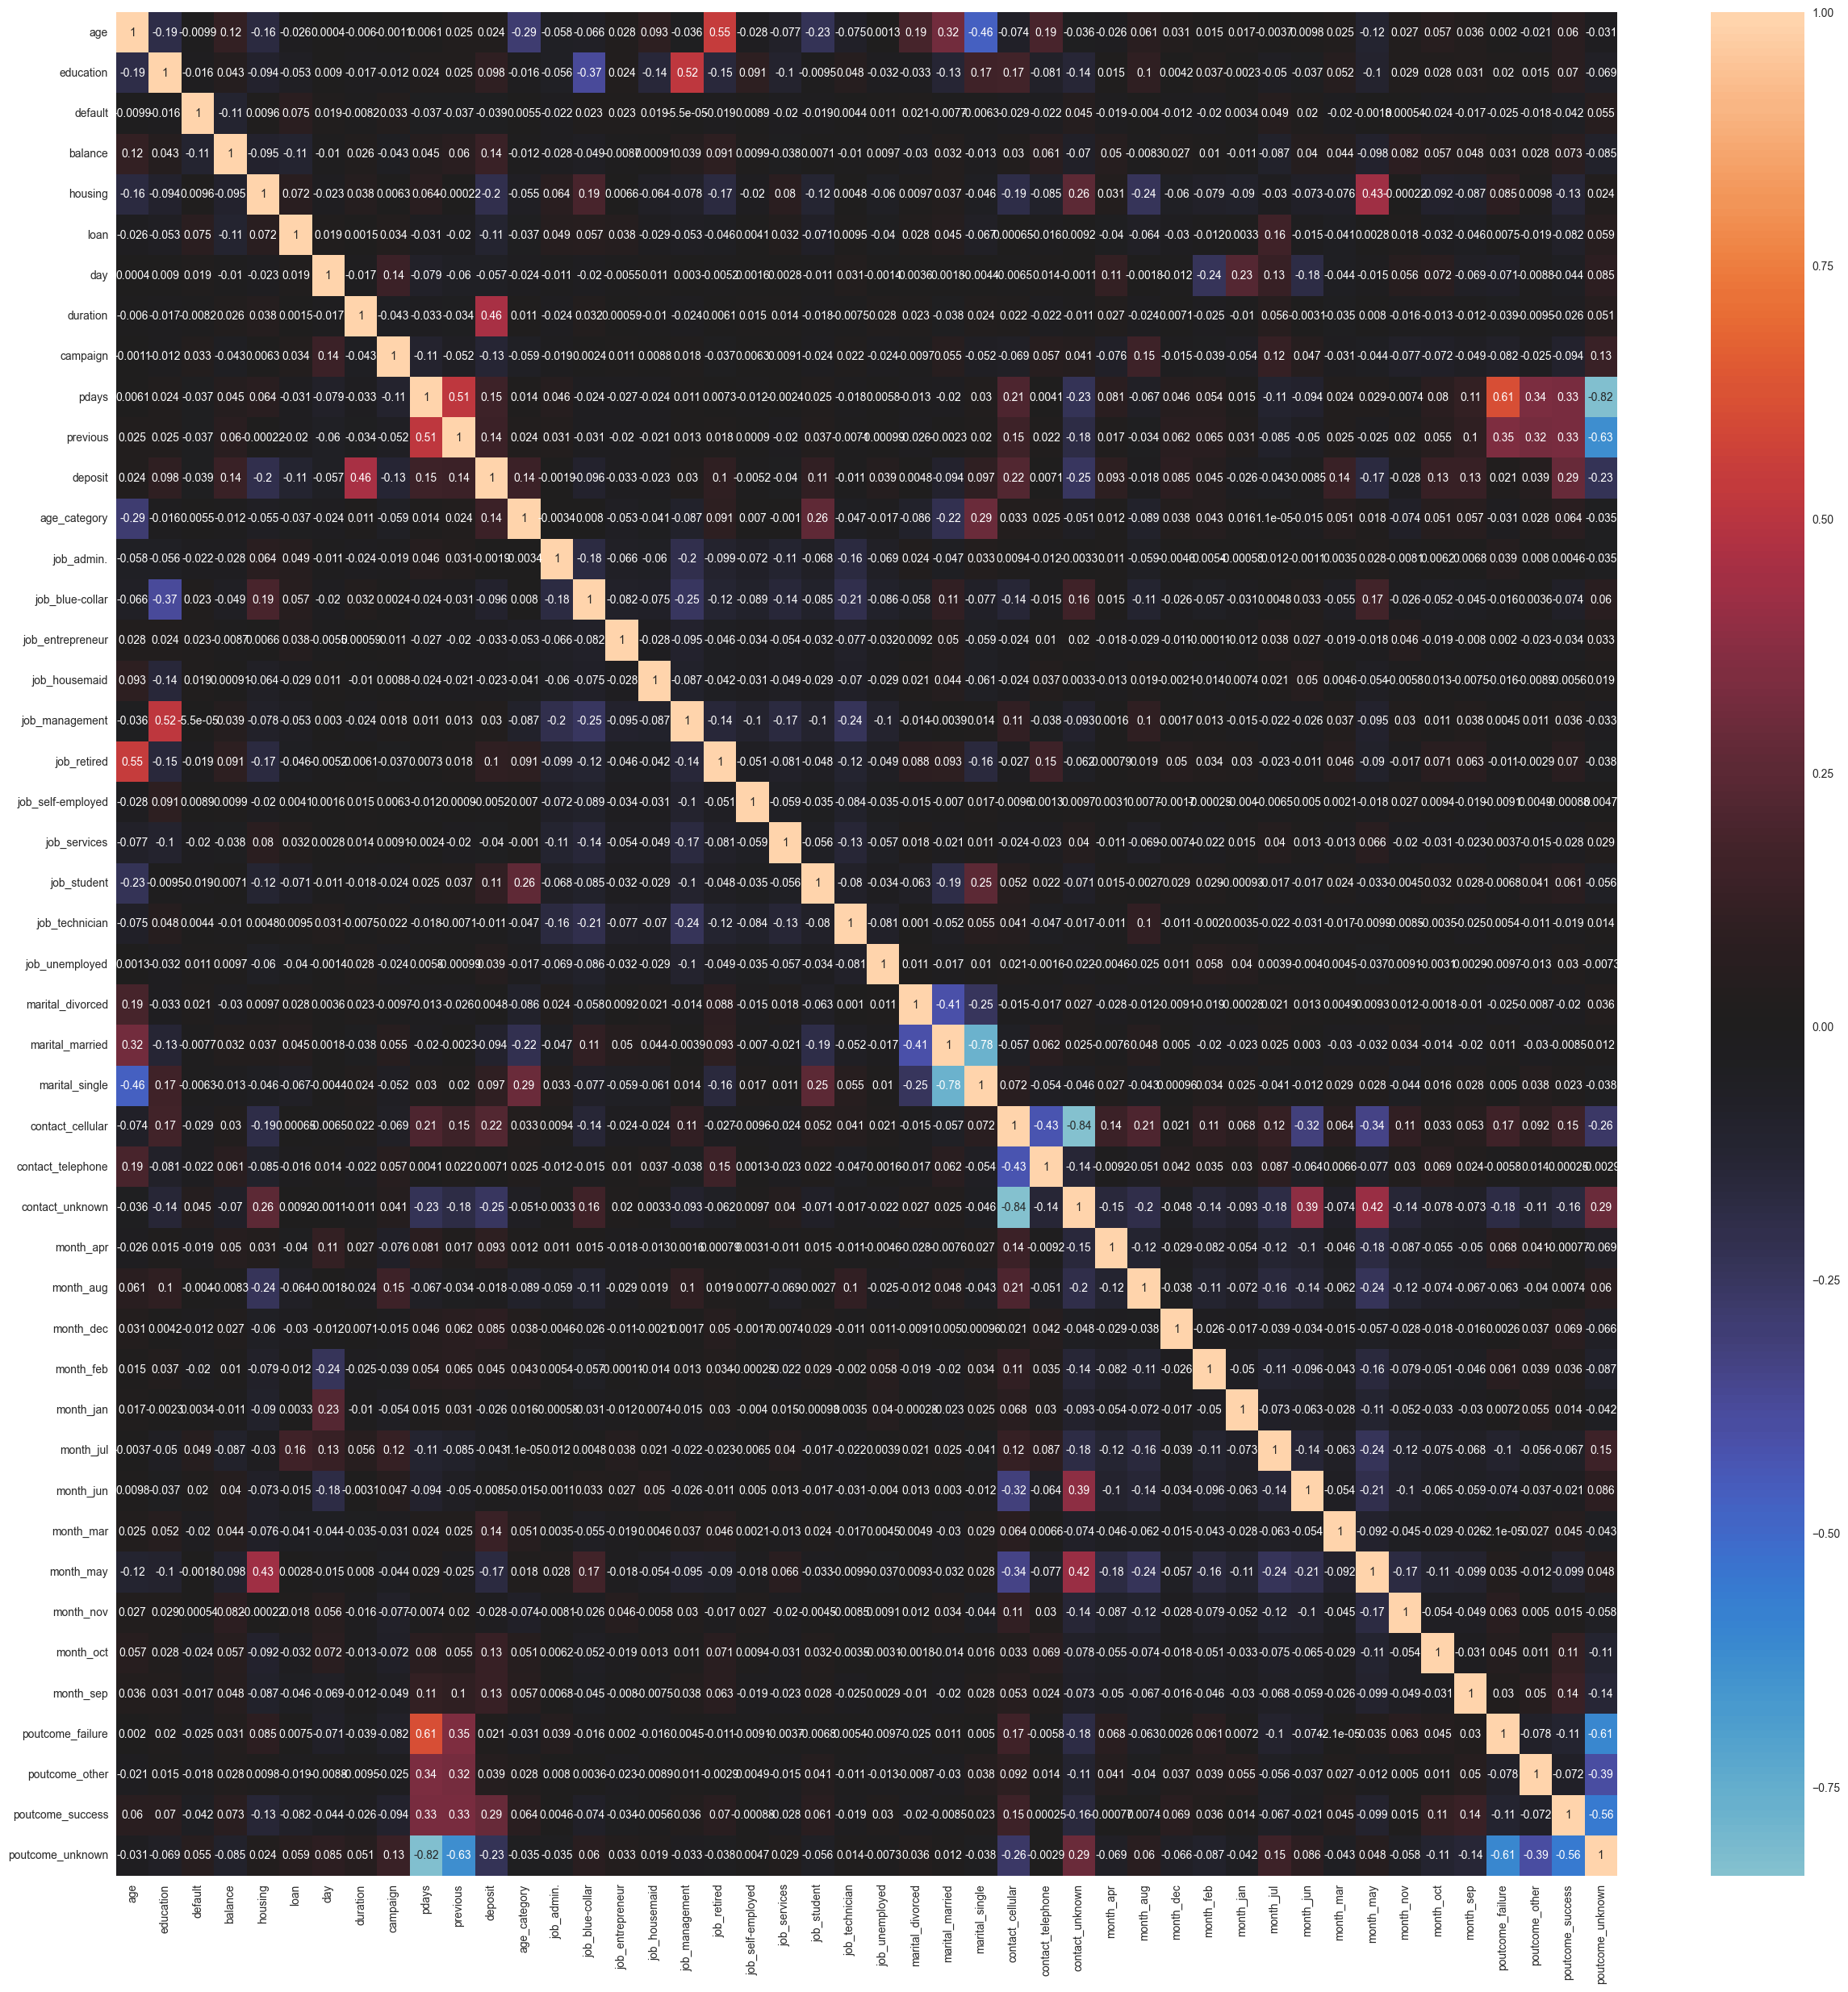

In [38]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности

plt.figure(figsize=(30,30))
sns.heatmap(data.corr(numeric_only=True), annot=True, center=0);
experiment.log_figure('correlations', plt)

**Данных с мультикорреляцией нет**

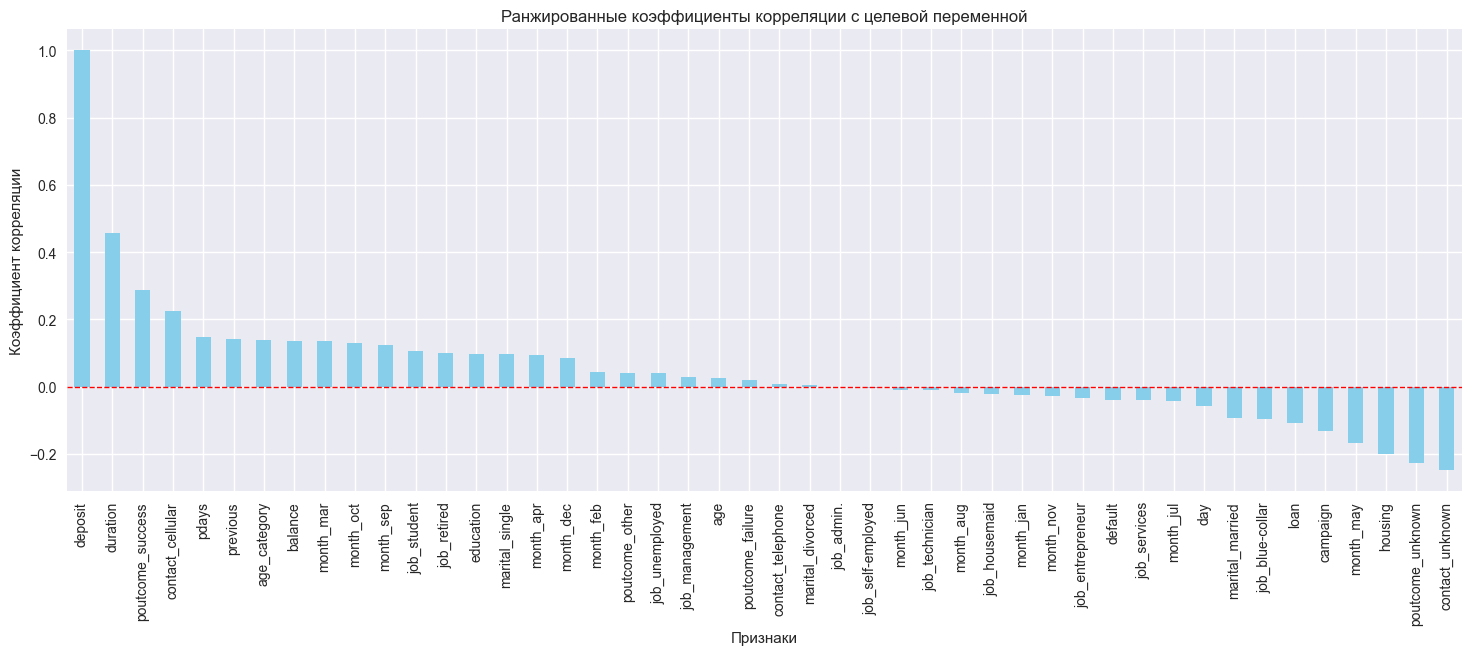

In [39]:
# Построим столбчатую диаграмму для ранжированных коэффициентов корреляции для целевого признака deposit

correlations = data.corr()['deposit']
sorted_correlations = correlations.sort_values(ascending=False)

plt.figure(figsize=(18, 6))
sorted_correlations.plot(kind='bar', color='skyblue')
plt.title("Ранжированные коэффициенты корреляции с целевой переменной")
plt.xlabel("Признаки")
plt.ylabel("Коэффициент корреляции")
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Линия уровня 0
experiment.log_figure('target_features_correlations', plt)
plt.show();

Видно, что наибольшая корреляция есть с признаками:
* Duration;
* poutcome_success;
* contact_celluar

однако, значения не высокие, в следствие чего оставляем эти признаки в датафрейме

In [40]:
# Разделим датасет и целевой признак и сформируем обучающую и тестовую выборку

X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
X_test.shape

(3335, 45)

In [41]:
# с помощью SelectKBest отбираем 15 наиболее подходящих признаков, запишем их в отдельный список

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

best_features = selector.get_feature_names_out().tolist()
best_features

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_category',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [42]:
# Повторно сформируем наши выборки, но уже только с использованием 15 наиболее важных признаков

X = data[best_features]
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
X_train.shape

(6770, 15)

In [43]:
# нормализуем данные с помощью minmaxsxaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
print(X_test_scaled[:,0].mean().round(2))

0.47


## Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [45]:
# обучим логистическую регрессию и рассчитаем метрики качества

model = linear_model.LogisticRegression(max_iter=1000, random_state=42, solver='sag')

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print('Отчет для обучающей выборки:', '\n', metrics.classification_report(y_train, y_train_pred))
print()
print('Отчет для тестовой выборки:', '\n', metrics.classification_report(y_test, y_test_pred))

accuracy_log_reg = metrics.accuracy_score(y_test, y_test_pred)
f1_score_log_reg = metrics.f1_score(y_test, y_test_pred)
experiment.log_metric('Accuracy_log_reg_model', accuracy_log_reg)
experiment.log_metric('F1-Score_log_reg_model', f1_score_log_reg)


Отчет для обучающей выборки: 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      3634
           1       0.84      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770


Отчет для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83      1790
           1       0.82      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



Из описательных статистики категориальныз перемен, мы видим, что:
* Клиенты заняты в 11 сферах труда, чаще всего это сфера менеджмента; 
* у большей части клиентов, нет просроченного кредита;
* кампания проводилась в течение всех 12 месяцев
* по большой части клиентов нет данных о результатах за предыдущую кампанию

In [46]:
# обучим решающие деревья, настроим максимальную глубину

model = tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=6,
    min_samples_split=10,
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print('Отчет для обучающей выборки:', '\n', metrics.classification_report(y_train, y_train_pred))
print()
print('Отчет для тестовой выборки:', '\n', metrics.classification_report(y_test, y_test_pred))

accuracy_decision_tree = metrics.accuracy_score(y_test, y_test_pred)
f1_score_decision_tree = metrics.f1_score(y_test, y_test_pred)
experiment.log_metric('Accuracy_log_reg_model', accuracy_decision_tree)
experiment.log_metric('F1-Score_log_reg_model', f1_score_decision_tree)

Отчет для обучающей выборки: 
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770


Отчет для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



In [47]:
# подберем оптимальные параметры с помощью gridsearch

param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42,
        criterion='entropy'
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

y_test_pred = grid_search.predict(X_test_scaled)

print('Отчет для тестовой выборки:', '\n', metrics.classification_report(y_test, y_test_pred))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

accuracy_grid_search = metrics.accuracy_score(y_test, y_test_pred)
f1_score_grid_search = metrics.f1_score(y_test, y_test_pred)
experiment.log_metric('Accuracy_grid_search', accuracy_grid_search)
experiment.log_metric('F1-Score_grid_search', f1_score_grid_search)

Отчет для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


## Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [48]:
# обучим на наших данных случайный лес

model = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('Отчет для обучающей выборки:', '\n', metrics.classification_report(y_train, y_train_pred))
print()
print('Отчет для тестовой выборки:', '\n', metrics.classification_report(y_test, y_test_pred))

accuracy_random_forest = metrics.accuracy_score(y_test, y_test_pred)
f1_score_random_forest = metrics.f1_score(y_test, y_test_pred)
experiment.log_metric('Accuracy_random_forest', accuracy_random_forest)
experiment.log_metric('F1-Score_random_forest', f1_score_random_forest)

Отчет для обучающей выборки: 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770


Отчет для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



In [49]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом

model = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=500,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('Отчет для обучающей выборки:', '\n', metrics.classification_report(y_train, y_train_pred))
print()
print('Отчет для тестовой выборки:', '\n', metrics.classification_report(y_test, y_test_pred))

accuracy_boosting = metrics.accuracy_score(y_test, y_test_pred)
f1_score_boosting = metrics.f1_score(y_test, y_test_pred)
experiment.log_metric('Accuracy_gradient_boosting', accuracy_boosting)
experiment.log_metric('F1-Score_gradient_boosting', f1_score_boosting)

Отчет для обучающей выборки: 
               precision    recall  f1-score   support

           0       0.92      0.91      0.91      3634
           1       0.90      0.90      0.90      3136

    accuracy                           0.91      6770
   macro avg       0.91      0.91      0.91      6770
weighted avg       0.91      0.91      0.91      6770


Отчет для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



На обучающей выборке GBC показал себя лучше, однако, на тестовой результат незначительно слабей

In [50]:
# объединим уже известные алгоритмы с помощью стекинга 

from sklearn.ensemble import StackingClassifier

# Передаем модели с параметрами, какие использовали ранее

estimators = [
    ('dt', tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=7, min_samples_split=10)),
    ('lr', linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')),
    ('gbc', ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, min_samples_leaf=5, max_depth=5, random_state=42))
]

# для мета модели используем модель логистической регрессии с параметрами по умолчанию

reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_split=10,
                                                       random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gbc',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=500,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [51]:
# Создадим предсказания и выведим 

y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

print('Отчет для обучающей выборки:', '\n', metrics.classification_report(y_train, y_train_pred))
print()
print('Отчет для тестовой выборки:', '\n', metrics.classification_report(y_test, y_test_pred))

accuracy_stacking = metrics.accuracy_score(y_test, y_test_pred)
f1_score_stacking = metrics.f1_score(y_test, y_test_pred)
experiment.log_metric('Accuracy_stacking', accuracy_stacking)
experiment.log_metric('F1-Score_stacking', f1_score_stacking)

Отчет для обучающей выборки: 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88      3634
           1       0.87      0.86      0.86      3136

    accuracy                           0.88      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.88      0.88      0.88      6770


Отчет для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.80      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335




 Топ 3 признака:
             Feature  Importance
2           duration    0.493586
13  poutcome_success    0.111033
0            balance    0.076521


<Figure size 800x600 with 0 Axes>

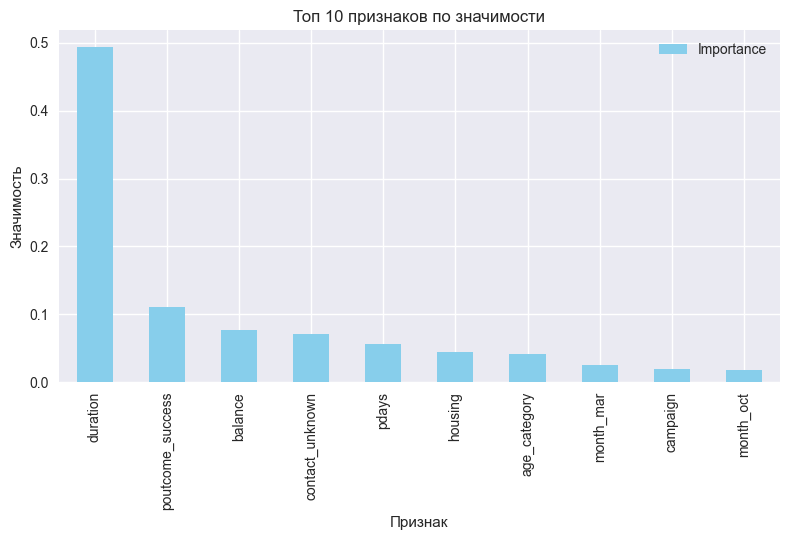

In [52]:
# Проверяем, есть ли имена признаков
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]

# Получение значимости признаков
feature_importances = model.feature_importances_

# Создаем DataFrame с именами признаков и их важностью
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Выбираем три наиболее важных признака
top_3_features = importance_df.head(3)

print("\n Топ 3 признака:")
print(top_3_features)

# Визуализация значимости признаков
plt.figure(figsize=(8, 6))
importance_df.set_index('Feature').head(10).plot(kind='bar', color='skyblue')
plt.title("Топ 10 признаков по значимости")
plt.ylabel("Значимость")
plt.xlabel("Признак")
plt.tight_layout()
experiment.log_figure('Feature_importance', plt)
plt.show();

In [53]:
# реализуем оптимизацию гиперпараметров с помощью Optuna

import optuna

random_state = 42

def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
    
    return score

In [54]:
# cоздаем объект исследования

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-12-13 12:46:05,471] A new study created in memory with name: RandomForestClassifier
[I 2024-12-13 12:46:07,168] Trial 0 finished with value: 0.9225938137855236 and parameters: {'n_estimators': 131, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9225938137855236.
[I 2024-12-13 12:46:08,621] Trial 1 finished with value: 0.8729316266000624 and parameters: {'n_estimators': 185, 'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9225938137855236.
[I 2024-12-13 12:46:10,407] Trial 2 finished with value: 0.8530150753768844 and parameters: {'n_estimators': 186, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9225938137855236.
[I 2024-12-13 12:46:11,999] Trial 3 finished with value: 0.8612021857923498 and parameters: {'n_estimators': 176, 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9225938137855236.
[I 2024-12-13 12:46:13,164] Trial 4 finished with value: 0.853037638606903 and parameters: {'n_e

In [55]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 163, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [56]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('Отчет для обучающей выборки:', '\n', metrics.classification_report(y_train, y_train_pred))
print()
print('Отчет для тестовой выборки:', '\n', metrics.classification_report(y_test, y_test_pred))

accuracy_optuna = metrics.accuracy_score(y_test, y_test_pred)
f1_score_optuna = metrics.f1_score(y_test, y_test_pred)
experiment.log_metric('Accuracy_random_forest_with_optuna', accuracy_optuna)
experiment.log_metric('F1-Score_random_forest_with_optuna', f1_score_optuna)
experiment.log_confusion_matrix(np.array(y_test), y_test_pred)

Отчет для обучающей выборки: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3634
           1       0.91      0.94      0.92      3136

    accuracy                           0.93      6770
   macro avg       0.93      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770


Отчет для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.84      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



{'web': 'https://www.comet.com/api/asset/download?assetId=7f2bf41a7b014a819cc70a1e46d9756d&experimentKey=2a0dfdff10ab4d4e9a3c9a26bc70f65d',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=7f2bf41a7b014a819cc70a1e46d9756d&experimentKey=2a0dfdff10ab4d4e9a3c9a26bc70f65d',
 'assetId': '7f2bf41a7b014a819cc70a1e46d9756d'}

**Нам удалось улучшить наш результат метрики F1 Score на тестовой выборке, также достигнуть результата 0.82 на метрике точности. Также видим, что recall на тестовой выборке достиг 0.84, что является лучшим результатом.**

In [58]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : warm_rattlesnake_8027
COMET INFO:     url                   : https://www.comet.com/apiona13/project-classification/2a0dfdff10ab4d4e9a3c9a26bc70f65d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy_gradient_boosting         : 0.8212893553223388
COMET INFO:     Accuracy_grid_search               : 0.8170914542728636
COMET INFO:     Accuracy_log_reg_model             : 0.8083958020989506
COMET INFO:     Accuracy_random_forest             : 0.8245877061469266
COMET INFO:     Accuracy_random_forest_with_optuna : 0.823688155922039
COMET INFO:     Accuracy_stacking                  : 0.8203898050974513
COMET INFO:     F1-Score_gradient_bo

Из описательных статистики категориальныз перемен, мы видим, что:
* Клиенты заняты в 11 сферах труда, чаще всего это сфера менеджмента; 
* у большей части клиентов, нет просроченного кредита;
* кампания проводилась в течение всех 12 месяцев
* по большой части клиентов нет данных о результатах за предыдущую кампанию